In [68]:
import numpy as np 
import networkx as nx
from tqdm import tqdm as tqdm 
from matplotlib import pyplot as plt

To recap what the article says:
1. You can make a directed navigable graph  with in-degree=out-degree = sqrt(n log n)
2. The construction is easy. For each node i,
- you add all the edges (j, i) for the m closest nodes, for m = sqrt(n log n)
- you add m=sqrt(n log n) random edges (i, j) [in the paper they don't call this m but I do].
Whp. the graph is navigable with length = 2. You can also make this construction deterministic.
The construction is based on property (1) in the paper, which is equivalent to navigability.
3. There is an almost tight LB. They create a graph with average degree almost sqrt(n), in the Euclidean space, with d > log n.

How can we improve? It would be interesting to see whether we can show that relaxing navigability can reduce by a lot the degree. For example, what if there is not a path from *every* source to every destination?
1. Then one candidate algorithm is to select k random initial points and then try to find a navigable path.
- A candidate construction, would be the one above, with a smaller value of incoming and outgoing edges, e.g., log n. Would then the power of k choices work?
2. We could even try this experimentally. Take their LB construction and try the construction with smaller m.
3. Another idea is to change the navigation algorithm. What if instead of visiting the closest node you visit the 2 (or higher) closest nodes and you check their nodes and you take the min or the 2 minima?
4. What if, when you are stuck, you are allowed to visit a further node? How many times do you have to follow a worse node?
Again, these can be tried first with their construction.

In [69]:
# Defining some utilities (early implementation, will be refactored in a class)

def randomEnvironment(n: int,
                      d: int):
    
    return np.random.multivariate_normal(np.zeros(d),
                                         np.eye(d),
                                         n)

def distanceBasedPermutation(x: np.array, 
                             ord = 2):
    
    DBP = np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            DBP[i,j] = np.linalg.norm(x[i] - x[j], ord)

    return np.argsort(DBP, 1)

def randomizedConstruction(x: np.array,
                           ord = 2,
                           m = None,
                           scheme = 'paper'):

    n = x.shape[0]
    A = np.zeros((n,n))

    DBP = distanceBasedPermutation(x, ord)
    if not m:
        m = int(np.floor(np.sqrt(3 * n * np.log(n))))

    for i in range(n):

        # Deterministic step
        A[i, DBP[i, 1:m]] = 1
        A[DBP[i,1:m], i]
        
        # Randomized step
        if scheme == 'paper':
            S = int(np.ceil(3 * n * np.log(n)/m))
        else:
            S = m
        R = np.random.choice(np.concatenate([np.arange(0,i), np.arange(i+1,n)]), S)

        A[i, R] = 1
        A[R, i] = 1

    return A


In [70]:
X = randomEnvironment(100, 5)

In [71]:
randomizedConstruction(X)

array([[0., 1., 0., ..., 0., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 1., 1., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 1., 0.]])

# Paper construction

Very dense graph with proved bounds on degree for navigability

In [72]:
A = randomizedConstruction(X)
G = nx.from_numpy_matrix(A)

In [73]:
np.mean(list(dict(G.degree()).values()))

76.22

_________

In [74]:
# Greedy routing algorithm

def greedyRouting(s: int,
                  t: int,
                  x: np.array,
                  A: np.array
                  ):
    
    done = False
    j = s

    steps = 0

    while not done:
        
        if np.all(A[j] == 0):
            done = True
            print(j)

        else:
            neighs = np.where(A[j] == 1)[0]
            X_ = np.copy(x[neighs])
            h = neighs[np.argmin(np.linalg.norm(X_ - x[t], axis = 1))]

            if np.linalg.norm(x[t] - x[h]) < np.linalg.norm(x[t] - x[j]):
                j = h
                steps += 1
                
            else:
                done = True


    return x[j], steps

In [87]:
X = randomEnvironment(100, 5)
A = randomizedConstruction(X)

s = np.random.randint(0,X.shape[0])
t = np.random.randint(0,X.shape[0])

X1, steps = greedyRouting(s, t, X, A)

42 86


In [88]:
np.all(X1 == X[t])

True

In [89]:
steps

1

Paper baseline is ok, now let's try to work out something sharper with a sparser graph. 

________

In [11]:
N = X.shape[0]

In [12]:
Ms = np.arange(1,np.sqrt(3 * N * np.log(N)))

In [13]:
Ms

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37.])

In [14]:
A = randomizedConstruction(X, 2, 2, 'other')
G = nx.from_numpy_matrix(A)
nx.is_connected(G)

True

In [15]:
np.mean(list(dict(G.degree()).values()))

5.38

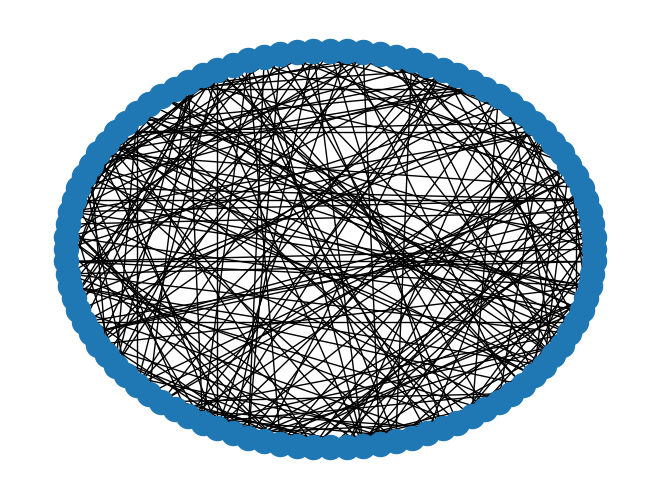

In [16]:
nx.draw_circular(G)

First simulation: 
+ Slightly modify the paper construction, considering $m$ closest nodes in the deterministic step and $m$ random nodes in the stochadtic one;
+ Perform the construction and perform random source-target greedy algorithm
+ Do it for all values for $m$ spanning from 1 to $\sqrt{3n\log n}$

In [90]:
def firstSimo(X,
              M = 50):
    
    N = X.shape[0]
    Ms = np.arange(2,np.sqrt(3 * N * np.log(N)), dtype='int32')
    STEPS = np.zeros(Ms.shape[0])
    AVG_DEGREE = np.zeros(Ms.shape[0])

    STEPS_SD = np.zeros(Ms.shape[0])
    AVG_DEGREE_SD = np.zeros(Ms.shape[0])
    
    for m in Ms:
    
        steps = np.zeros(M)
        avg_degree = np.zeros(M)

        for i in tqdm(range(M)):
            A = randomizedConstruction(X, 2, m, 'other')
            G = nx.from_numpy_matrix(A)

            avg_degree[i] = np.mean(list(dict(G.degree()).values()))

            s = np.random.randint(0,X.shape[0])
            t = np.random.randint(0,X.shape[0])

            D, steps_ = greedyRouting(s, 
                                      t,
                                      X, 
                                      A)

            if np.all(D == X[t]):
                steps[i] = steps_
            else:
                steps[i] = np.inf

        STEPS[m - 2] = np.mean(steps)
        AVG_DEGREE[m - 2] = np.mean(avg_degree)

        STEPS_SD[m - 2] = np.std(steps)
        AVG_DEGREE_SD[m - 2] = np.std(avg_degree)

    return STEPS, AVG_DEGREE, STEPS_SD, AVG_DEGREE_SD

In [96]:
X = randomEnvironment(200, 5)
X.shape

(200, 5)

In [97]:
steps, avgd, steps_sd, avgd_sd = firstSimo(X)

100%|██████████| 50/50 [00:09<00:00,  5.49it/s]


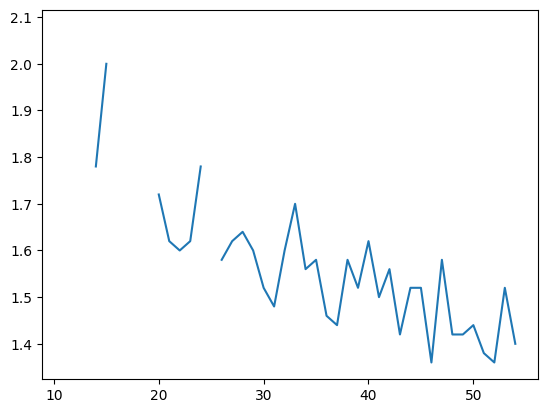

In [98]:
plt.plot(steps)

In [99]:
steps

array([ inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
       2.08,  inf,  inf, 1.78, 2.  ,  inf,  inf, 1.86,  inf, 1.72, 1.62,
       1.6 , 1.62, 1.78,  inf, 1.58, 1.62, 1.64, 1.6 , 1.52, 1.48, 1.6 ,
       1.7 , 1.56, 1.58, 1.46, 1.44, 1.58, 1.52, 1.62, 1.5 , 1.56, 1.42,
       1.52, 1.52, 1.36, 1.58, 1.42, 1.42, 1.44, 1.38, 1.36, 1.52, 1.4 ])

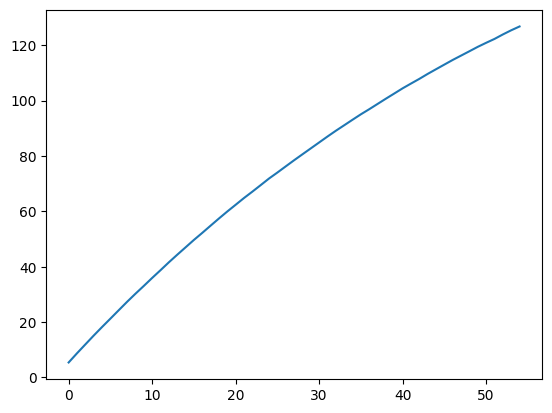

In [100]:
plt.plot(avgd)

In [101]:
avgd

array([  5.4244,   8.743 ,  11.9456,  15.1354,  18.2274,  21.2514,
        24.2948,  27.3302,  30.246 ,  33.0632,  35.9468,  38.7388,
        41.588 ,  44.3196,  46.9924,  49.671 ,  52.219 ,  54.8268,
        57.4212,  59.946 ,  62.369 ,  64.813 ,  67.1082,  69.4708,
        71.8592,  74.0126,  76.2384,  78.4494,  80.5968,  82.7342,
        84.8736,  87.0164,  89.0982,  91.0826,  93.0802,  95.0454,
        96.8812,  98.7884, 100.693 , 102.553 , 104.4254, 106.1446,
       107.8342, 109.6312, 111.3212, 113.0018, 114.675 , 116.2436,
       117.8168, 119.4068, 120.8612, 122.2574, 123.873 , 125.3806,
       126.7536])